In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import re
import pandas
from io import StringIO
import numpy as np
from itertools import product, chain
import seaborn as sns
import sys 
from Bio import SeqIO, SeqRecord

In [2]:
fwd='''
>01
TACTGCTGTAATACGACTCACTATAGG
>03
CTACTGCATAATACGACTCACTATAGG
>05
CTCGTGAGTAATACGACTCACTATAGG
>07
CTATATCGTAATACGACTCACTATAGG
>09
ATAGTACTTAATACGACTCACTATAGG
>11
CTATGAGTTAATACGACTCACTATAGG
'''
rev='''
>A_
GCTAGAGTGCTAGTTATTGCTCAGCGG
>C_
TGAGACAGGCTAGTTATTGCTCAGCGG
>E_
CACAGACAGCTAGTTATTGCTCAGCGG
>G_
TCATGCTCGCTAGTTATTGCTCAGCGG
>I_
CGTGAGCAGCTAGTTATTGCTCAGCGG
>K_
GAGCTATAGCTAGTTATTGCTCAGCGG
'''

In [3]:
# part of the forward primer. If a hit has this in it more than 1 time, 
# it is a chimera 

def is_chimera( str_read, primer_part='ACTCACTATAGG', rev_primer_part='CCGCTGAGCAATAAC' ):
    if len(re.findall(primer_part, ''.join(str_read))) > 1:
        return True
    if len(re.findall(rev_primer_part, ''.join(str_read))) > 1:
        return True 

fwd = [r for r in SeqIO.parse(StringIO(fwd), 'fasta')]
rev = [r for r in SeqIO.parse(StringIO(rev), 'fasta')]
for r in rev:
    r.seq = r.reverse_complement().seq

In [4]:
src = 'output_files/job_output_ccs/tasks/pbcoretools.tasks.bam2fastq_ccs-0/ccs' 
searches = [(f, r, re.compile('{}.*{}'.format(''.join(f.seq),''.join(r.seq)))) for f, r in product( fwd, rev )]
dat = []

In [5]:
length = len(list(SeqIO.parse( src, 'fastq' )))
print( length, 'consensus reads to process' ) 

28169 consensus reads to process


In [6]:
for i, rec in enumerate(SeqIO.parse(src, 'fastq')):
    for f, r, search in searches:
        str_seq = ''.join(chain(rec.seq, rec.reverse_complement()))
        for find in re.finditer( search, str_seq ):
            start, stop = find.span()
            if stop - start > 500:
                sub_str = rec.seq[start:stop]
                if not is_chimera(sub_str):
                    sub_qual = rec.letter_annotations['phred_quality'][start:stop]
                    fas = SeqRecord.SeqRecord(sub_str, id=rec.id, letter_annotations={'phred_quality':sub_qual})
                    dat.append((str(r.id + f.id), fas, len(sub_str)))
    sys.stdout.write('\rFinished {}/{}'.format(i, length))
    sys.stdout.flush()
    if i == 100000:
        break 

Finished 28168/28169

In [7]:
def is_outlier(points, thresh=1.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

In [8]:
def is_outlier(y, thresh=1.5):
#def doubleMADsfromMedian(y,thresh=3.5):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

/usr/local/bin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


A_01 127 inlier reads written to analysis_results/A_01.fasta


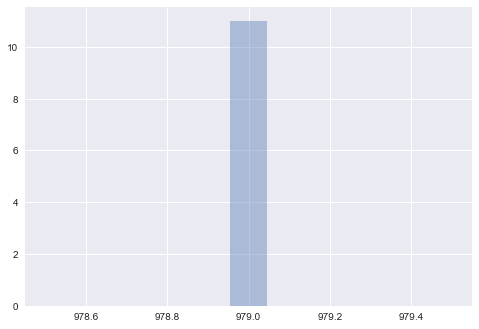

A_02 323 inlier reads written to analysis_results/A_02.fasta


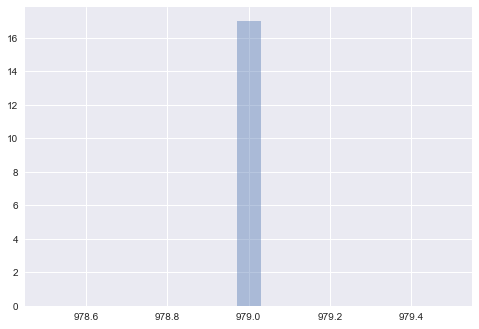

A_03 163 inlier reads written to analysis_results/A_03.fasta


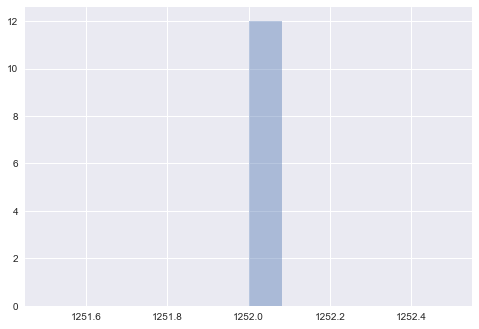

A_04 218 inlier reads written to analysis_results/A_04.fasta


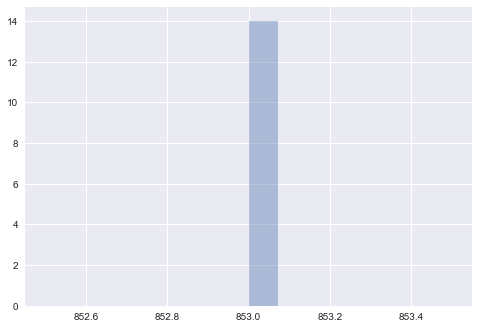

A_05 172 inlier reads written to analysis_results/A_05.fasta


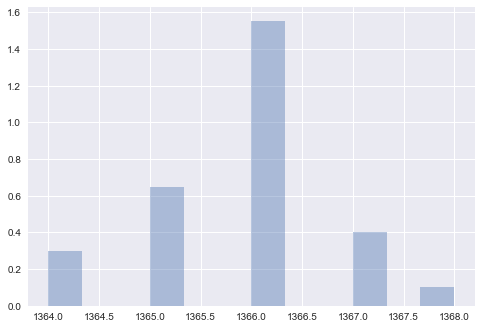

A_06 179 inlier reads written to analysis_results/A_06.fasta


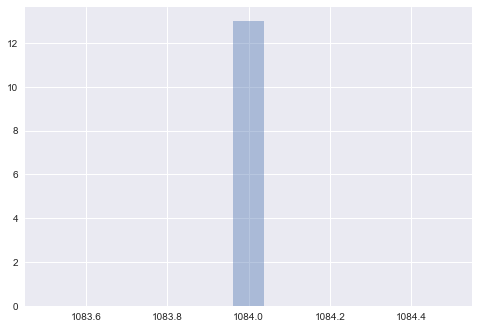

B_01 43 inlier reads written to analysis_results/B_01.fasta


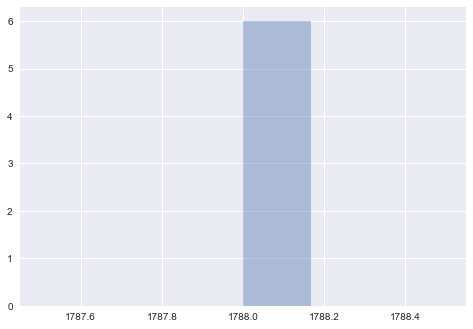

B_02 92 inlier reads written to analysis_results/B_02.fasta


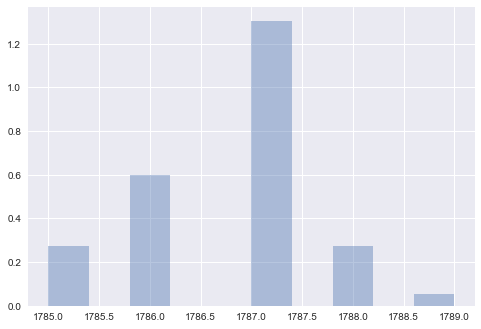

B_03 99 inlier reads written to analysis_results/B_03.fasta


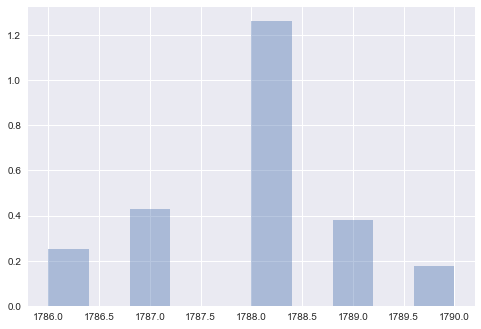

B_04 138 inlier reads written to analysis_results/B_04.fasta


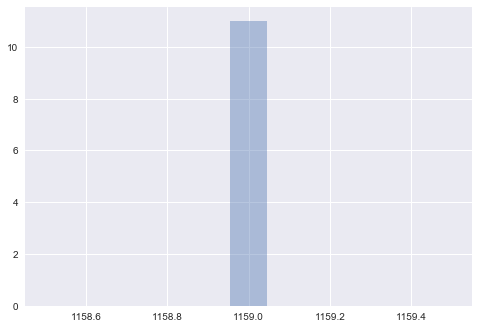

B_05 182 inlier reads written to analysis_results/B_05.fasta


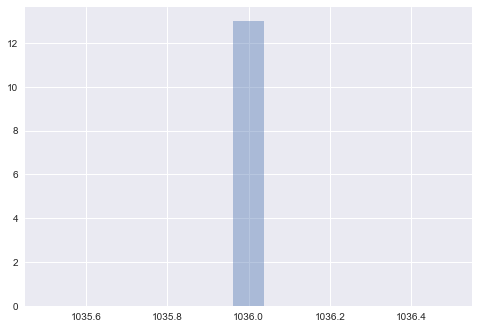

B_06 112 inlier reads written to analysis_results/B_06.fasta


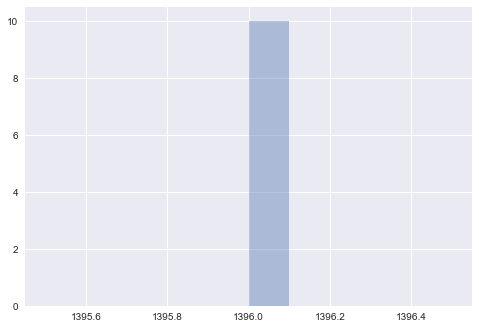

C_01 253 inlier reads written to analysis_results/C_01.fasta


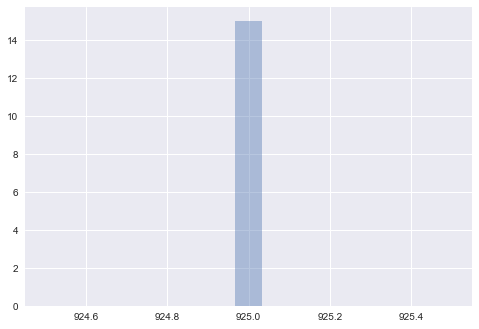

C_02 202 inlier reads written to analysis_results/C_02.fasta


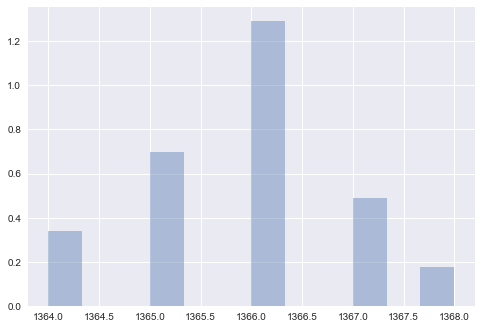

C_03 109 inlier reads written to analysis_results/C_03.fasta


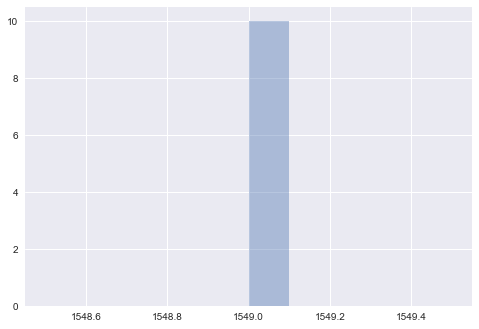

C_04 86 inlier reads written to analysis_results/C_04.fasta


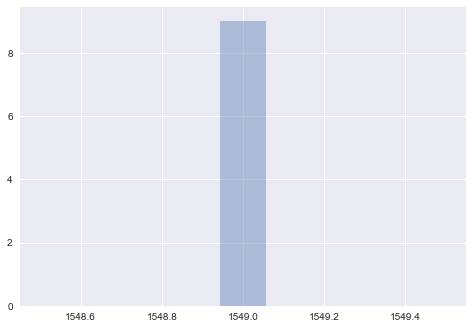

C_05 86 inlier reads written to analysis_results/C_05.fasta


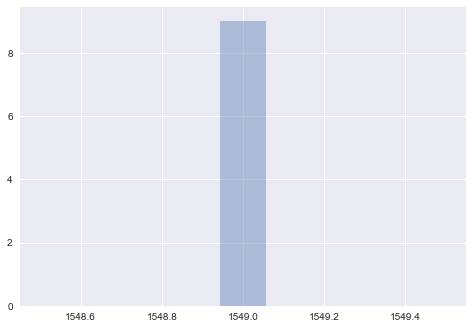

C_06 92 inlier reads written to analysis_results/C_06.fasta


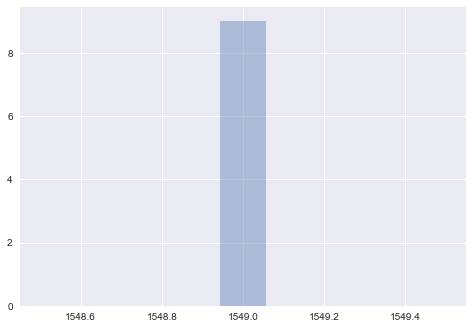

D_01 153 inlier reads written to analysis_results/D_01.fasta


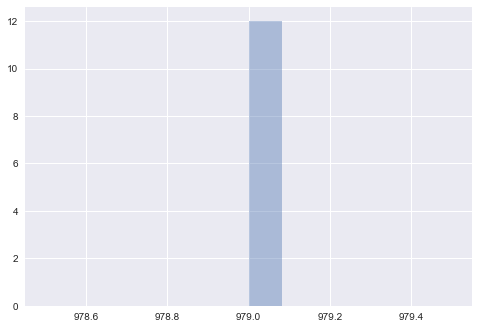

D_02 382 inlier reads written to analysis_results/D_02.fasta


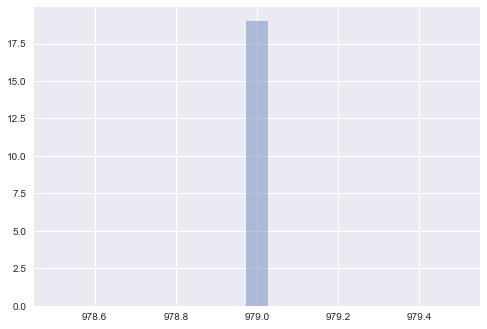

D_03 186 inlier reads written to analysis_results/D_03.fasta


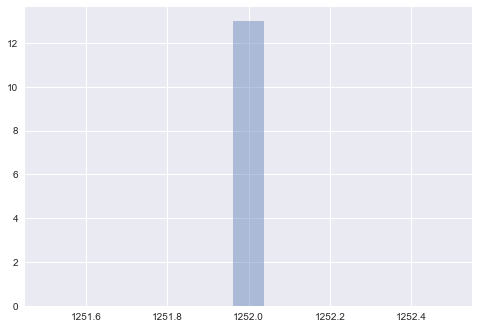

D_04 286 inlier reads written to analysis_results/D_04.fasta


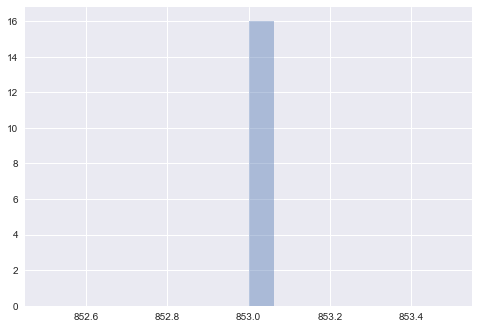

D_05 100 inlier reads written to analysis_results/D_05.fasta


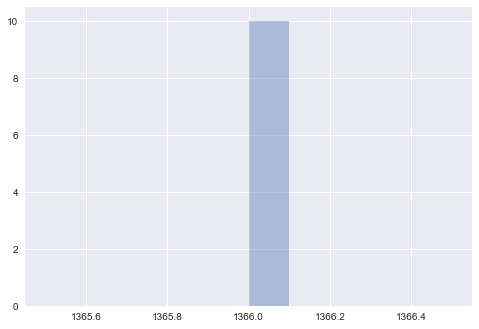

D_06 171 inlier reads written to analysis_results/D_06.fasta


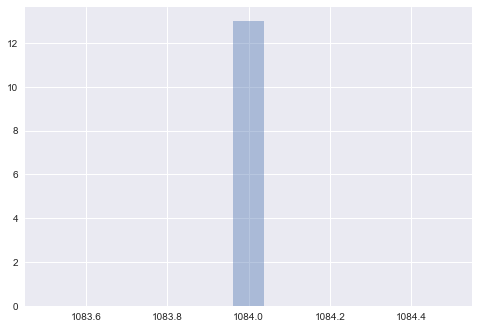

E_01 80 inlier reads written to analysis_results/E_01.fasta


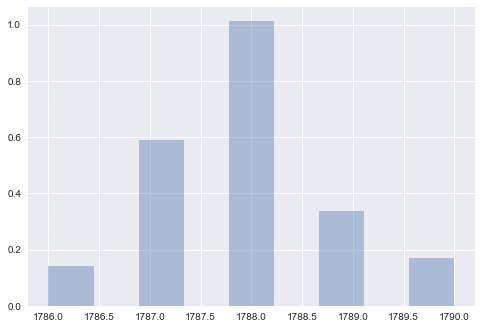

E_02 111 inlier reads written to analysis_results/E_02.fasta


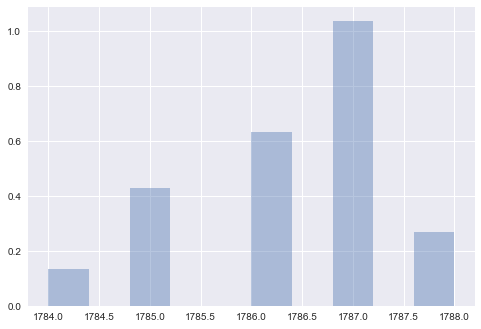

E_03 111 inlier reads written to analysis_results/E_03.fasta


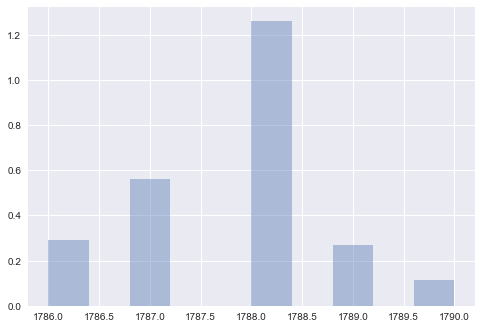

E_04 167 inlier reads written to analysis_results/E_04.fasta


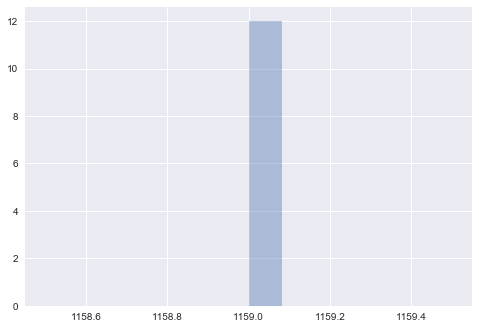

E_05 280 inlier reads written to analysis_results/E_05.fasta


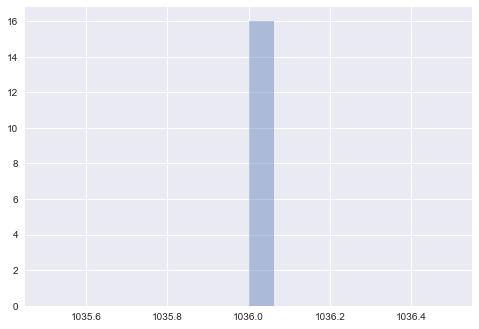

E_06 135 inlier reads written to analysis_results/E_06.fasta


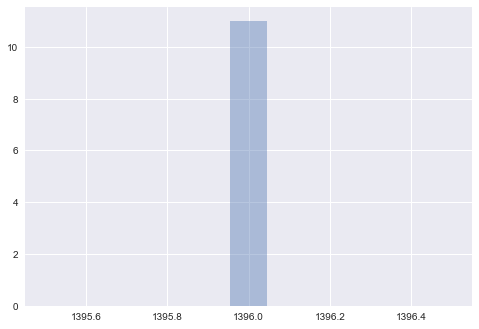

F_01 254 inlier reads written to analysis_results/F_01.fasta


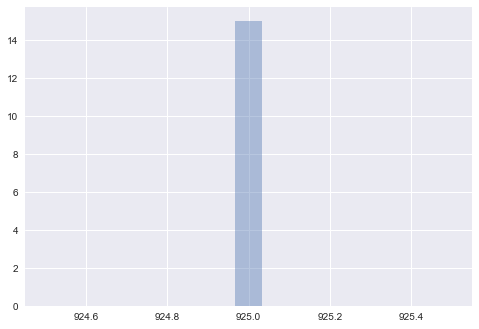

F_02 221 inlier reads written to analysis_results/F_02.fasta


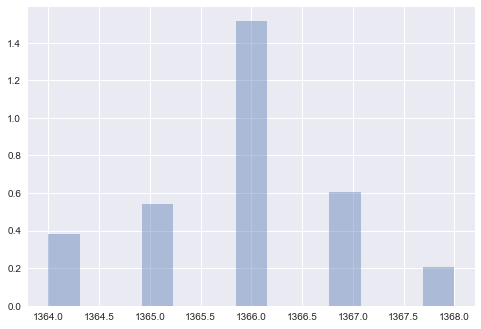

F_03 105 inlier reads written to analysis_results/F_03.fasta


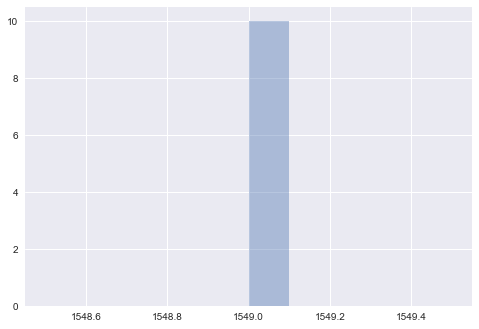

F_04 93 inlier reads written to analysis_results/F_04.fasta


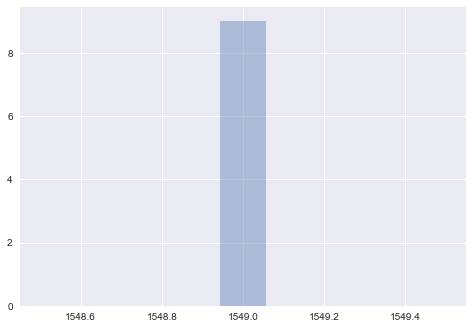

F_05 100 inlier reads written to analysis_results/F_05.fasta


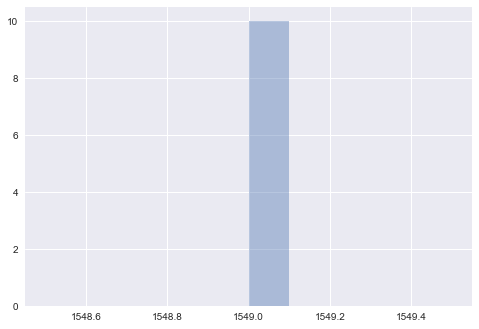

F_06 78 inlier reads written to analysis_results/F_06.fasta


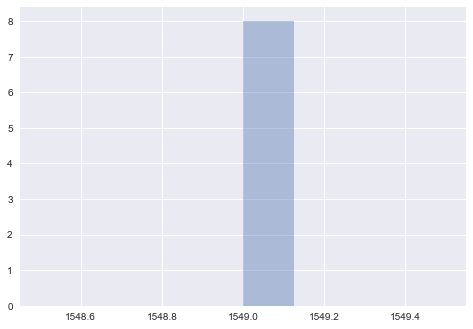

Total reads demultiplexed 5689


In [37]:
cols = [ 'well', 'seq_obj', 'x' ] # x is length of read 
df = pandas.DataFrame(dat, columns=cols)
df = df.query('x>500')
from collections import Counter
total_reads_demultiplexed = 0 
for idx, gdf in df.groupby( by='well' ):
    mask = is_outlier(gdf.x)
    gdf = gdf.loc[~mask]
    out_fn = 'analysis_results/{}.fasta'.format(idx) 
    SeqIO.write(gdf.seq_obj, out_fn, 'fasta')
    print( idx, len(gdf), 'inlier reads written to', out_fn )
    total_reads_demultiplexed += len(gdf) 
    sns.distplot(gdf.x.values, kde=False, norm_hist=True)
    plt.show()
print( 'Total reads demultiplexed', total_reads_demultiplexed )

In [10]:
! wc -l analysis_results/*fasta

    2286 analysis_results/A_01.fasta
     270 analysis_results/A_01_aln.fasta
     918 analysis_results/A_02.fasta
     918 analysis_results/A_02_aln.fasta
    5814 analysis_results/A_03.fasta
     572 analysis_results/A_03_aln.fasta
     576 analysis_results/A_04.fasta
     576 analysis_results/A_04_aln.fasta
    3586 analysis_results/A_05.fasta
     384 analysis_results/A_05_aln.fasta
     520 analysis_results/A_06.fasta
     520 analysis_results/A_06_aln.fasta
    3488 analysis_results/A_07.fasta
    4128 analysis_results/A_09.fasta
    3580 analysis_results/A_11.fasta
     310 analysis_results/B_01.fasta
     310 analysis_results/B_01_aln.fasta
     279 analysis_results/B_02.fasta
     279 analysis_results/B_02_aln.fasta
     310 analysis_results/B_03.fasta
     310 analysis_results/B_03_aln.fasta
     252 analysis_results/B_04.fasta
     252 analysis_results/B_04_aln.fasta
     456 analysis_results/B_05.fasta
     456 analysis_results/B_05_aln.fasta
     400 analysis_results/B_06.

In [11]:
! mafft --auto --localpair analysis_results/F_02.fasta


generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.305b alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
0 thread(s)

Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
treein = 0
compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    15 /16 c
Reallocating..done. *alloclen = 3734
STEP    16 /16 c
done.
tbfast (nuc) Version 7.305b alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
Loading 'hat3' ... done.
generating a scoring matrix for nucleotide (dist=200) ... done

   10 / 17
Segment   1/  1    1-1371
STEP 002-015-1  identical.    identical.    identical.    ident

In [12]:
! open -a Finder . 